# consumer_loans_classification

Rybczyński Jędrzej, 25.07.2022

In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec as gridspec

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, matthews_corrcoef
from sklearn.metrics import roc_curve, precision_recall_curve, plot_confusion_matrix

from catboost import CatBoostClassifier
from catboost import metrics as cb_metrics
from catboost import Pool, cv

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

import sys  
sys.path.insert(0, 'C:/Users/jrybczyn/Desktop/ds_onboarding_tasks/task_1/scripts')

import warnings
warnings.filterwarnings('ignore')

<br>

## EDA

### Data Loading

In [2]:
df = pd.read_csv('loans.csv')

In [3]:
df

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...,...
995,995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,996,40,male,3,own,little,little,3857,30,car,good
997,997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,998,23,male,2,free,little,little,1845,45,radio/TV,bad


In [4]:
print([str(x) for x in df.dtypes.values.tolist()])

['int64', 'int64', 'object', 'int64', 'object', 'object', 'object', 'int64', 'int64', 'object', 'object']


In [5]:
df.dtypes.values.tolist()

[dtype('int64'),
 dtype('int64'),
 dtype('O'),
 dtype('int64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('int64'),
 dtype('int64'),
 dtype('O'),
 dtype('O')]

Widzimy, że pierwsza kolumna to pewne ID dla wierszy, więc możemy ją śmiało zignorować.

In [6]:
df = df.iloc[:, 1:]

In [7]:
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


### Features Overview

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


Categorical features: 
- Sex
- Job (encoded int)
- Housing
- Saving accounts
- Checking account
- Purpose

Numerical features:
- Credit amount
- Duration

Target variable:
- Risk (binary classification)

In [9]:
# df.Job = df.Job.astype(str)

### Missing values

In [10]:
def missing(df):
    perc_missing = (df.isnull().sum() * 100 / len(df)).round(2)
    missing_value_df = pd.DataFrame({'num_missing': df.isnull().sum(),
                                     'perc_missing': perc_missing})
    missing_value_df = missing_value_df[missing_value_df.num_missing != 0]
    return missing_value_df.sort_values(by='perc_missing', ascending=False)

In [11]:
missing(df)

,num_missing,perc_missing
Checking account,394,39.4
Saving accounts,183,18.3


Sporo niewiadomych, zwłaszcza dla kolumny `Checking account`.

In [12]:
df['Checking account'].value_counts().to_frame()

,Checking account
little,274
moderate,269
rich,63


In [13]:
df['Saving accounts'].value_counts().to_frame()

,Saving accounts
little,603
moderate,103
quite rich,63
rich,48


W późniejszym procesie 'handlowania' (XD) brakujących wartości nasuwają mi się na ten moment dwie możliwości: 
- wprowadzenie stringa 'NAN' jako dodatkowa kategoria, jako że jest ich całkiem sporo,
- branie wartości średniej dla kategorii, czyli wartości `moderate`.

### Target variable distribution

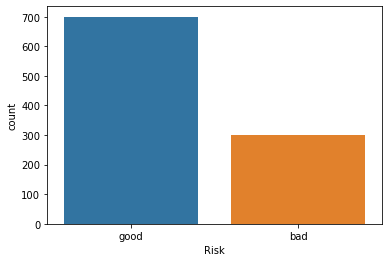

In [14]:
sns.countplot(x='Risk', data=df);

In [15]:
df['Risk'].value_counts().to_frame()

,Risk
good,700
bad,300


Nieco niezbalansowana zmienna wyjściowa Risk, do przemyślenia czy będzie warto zastosować Under/Over-Sampling.

### Pandas profiling

In [16]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)

In [17]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Najważniejsze wnioski z pandas-profiling:
- wysoka korelacja pomiędzy cechami `Duration` - `Credit Amount`
- 18.3% missing values dla `Saving accounts`, 39.4% dla `Checking account`
- szczegółowe korelacje pomiędzy zmienną wyjściową `Risk`, a wszystkimi cechami opiszę poniżej

### Features correlations with target variable

In [18]:
correlations = profile.description_set['correlations']
correlations.keys()

dict_keys(['spearman', 'pearson', 'kendall', 'cramers', 'phi_k'])

In [19]:
correlations['cramers']['Risk'].sort_values(ascending=False)

Risk                1.000000
Checking account    0.157656
Saving accounts     0.137713
Housing             0.127334
Purpose             0.081497
Sex                 0.065969
Job                 0.000000
Name: Risk, dtype: float64

Na podstawie współczynnika V-Cramera widzimy, że cechy jakościowe, które są najbardziej skorelowane ze zmienną wyjściową `Risk` to `Checking account`, `Saving accounts` oraz `Housing`, nie są to jednak zbyt duże wartości, oscylują na poziomie 0.1-0.15. Intuicyjnie wydaje się być dosyć jasne, że to właśnie te cechy są z nią najbardziej skorelowane, wszystkie z nich opisują w pewnym sensie majątek klienta, tak więc najbardziej oddają jego zdolność kredytową.

In [20]:
correlations['phi_k']['Risk'].sort_values(ascending=False)

Risk                1.000000
Duration            0.285273
Credit amount       0.240898
Saving accounts     0.207763
Age                 0.147761
Purpose             0.108971
Sex                 0.103450
Checking account    0.095274
Housing             0.076848
Job                 0.000000
Name: Risk, dtype: float64

Z kolei po zastosowaniu współczynnika Phi-K, który jest pewnym rozszerzeniem V-Cramera, widzimy już korelacje na poziomie 0.25-0.3 ze zmiennymi ciągłymi `Duration` oraz `Credit amount`, pojawia się też wcześniejsze `Saving accounts`.

Warto zauważyć całkowity brak korelacji między cechą `Job`, a zmienną wyjściową, warto więc rozważyć usunięcie tej cechy w późniejszym etapie.

### `Job` vs `Risk` independence test

In [21]:
obs = pd.crosstab(df.Job, df.Risk)
obs

Risk,bad,good
Job,,
0,7,15
1,56,144
2,186,444
3,51,97


In [22]:
from scipy.stats import chi2_contingency

# H_0 są niezależne
# H_1 są zależne
c, p, dof, expected = chi2_contingency(obs)
p

0.5965815918843431

p_value = 0.6, zatem faktycznie nie ma podstaw do odrzucenia H_0 jakoby zmienne `Job` i `Risk` były niezależne.

### Features Distribution

In [23]:
def show_dist(df, var):
    fig = plt.figure(constrained_layout=True, figsize=(10, 5))
    grid = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
    
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram of %s' % var)
    sns.distplot(df.loc[:, var], ax=ax1);
    
    ax2 = fig.add_subplot(grid[0, 2])
    ax2.set_title('Box Plot of %s' % var)
    sns.boxplot(y=df.loc[:, var], ax=ax2);

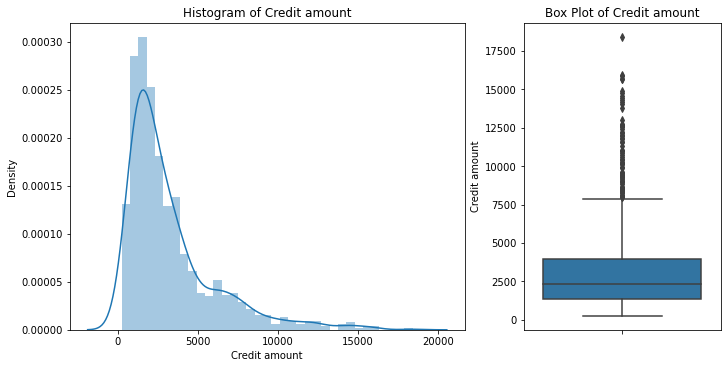

In [24]:
show_dist(df, 'Credit amount');

Widzimy, że mamy do czynienia z right-skewed, jako, że `Credit amount` będzie prawdopobnie jedną z kluczowych cech dla predykcji, należałoby rozważyć normalizacje zmiennej.

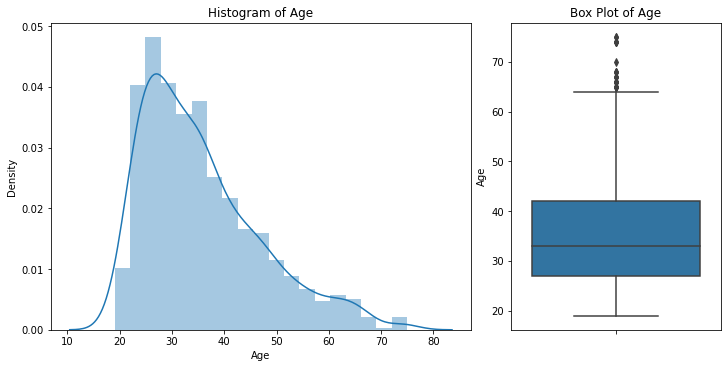

In [25]:
show_dist(df, 'Age');

<br>

## Features engineering

### Missing values

In [26]:
missing(df)

,num_missing,perc_missing
Checking account,394,39.4
Saving accounts,183,18.3


In [27]:
for feature in missing(df).index:
    df[feature] = df[feature].fillna('NAN')

In [28]:
missing(df)

,num_missing,perc_missing


Na początku zastosuje podejście z encodowaniem brakujących wartości jako `NAN`, sprawdzę później też różnice w skuteczności modelu z encodowaniem jako `moderate`.

In [29]:
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
correlations = profile.description_set['correlations']

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [30]:
correlations['cramers']['Risk'].sort_values(ascending=False)

Risk                1.000000
Checking account    0.347619
Saving accounts     0.179240
Housing             0.127334
Purpose             0.081497
Sex                 0.065969
Job                 0.000000
Name: Risk, dtype: float64

In [31]:
correlations['phi_k']['Risk'].sort_values(ascending=False)

Risk                1.000000
Checking account    0.512074
Duration            0.285273
Credit amount       0.240898
Age                 0.147761
Saving accounts     0.146780
Purpose             0.108971
Sex                 0.103450
Housing             0.076848
Job                 0.000000
Name: Risk, dtype: float64

Po zastosowaniu dodatkowej kategorii 'NAN' dla missing values widzimy, że nastąpnił znaczący wzrost w korelacji pomiędzy zmienną wyjściową `Risk`, a `Checking account`. Spróbujemy to zniwelować stosując KNNImputer, aby zastosować KNNImputer musimy jednak najpierw zakodować zmienną wyjściową oraz cechy jakościowe. Ponieważ zarówno Phi-K jak i V-Cramer pokazały, że Job nie jest w żaden sposób skorelowane ze zmienną wyjściową usuńmy tą cechę.

In [32]:
df = pd.read_csv('loans.csv')
df = df.iloc[:, 1:]
df.Job = df.Job.astype('str')

### Target variable encoding

In [33]:
df['Risk'] = np.where(df['Risk'] == 'bad', 1, 0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,0
1,22,female,2,own,little,moderate,5951,48,radio/TV,1
2,49,male,1,own,little,NaN,2096,12,education,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,0
4,53,male,2,free,little,little,4870,24,car,1


### Adding new features 

To co nasunęło mi się już w momencie kiedy zobaczyłem dataset to to, że nie mamy zmiennej, która przedstawia miesięczną ratę, dodajmy więc tą cechę poprzez podzielenie: $$\frac{\text{Credit amount}}{\text{Duration}}$$

In [34]:
rate = df['Credit amount'] / df['Duration']
df.insert(loc=9, column='Rate', value=rate) # tutaj robię to tylko po to żeby się wrzuciło przed kolumną Risk

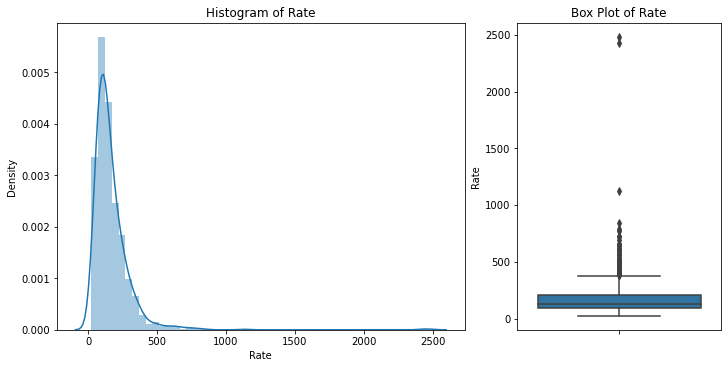

In [35]:
show_dist(df, 'Rate');

Right-skewed, którego można było się spodziewać, podobnie jak w przypadku `Credit amount`.

### Skew reduction attempt

In [36]:
# df['Credit amount'] = np.log1p(df['Credit amount'])
# df['Rate'] = np.log1p(df['Rate'])

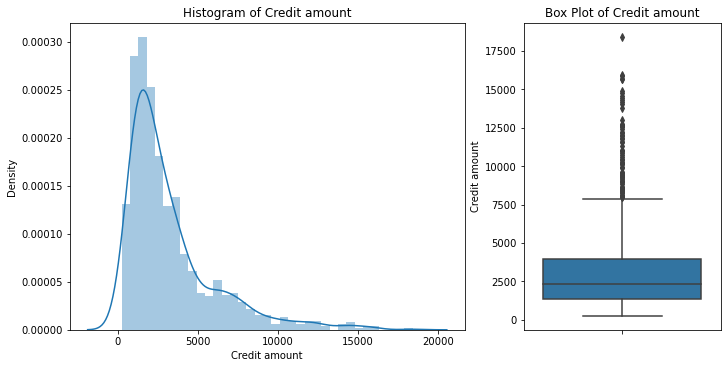

In [37]:
show_dist(df, 'Credit amount');

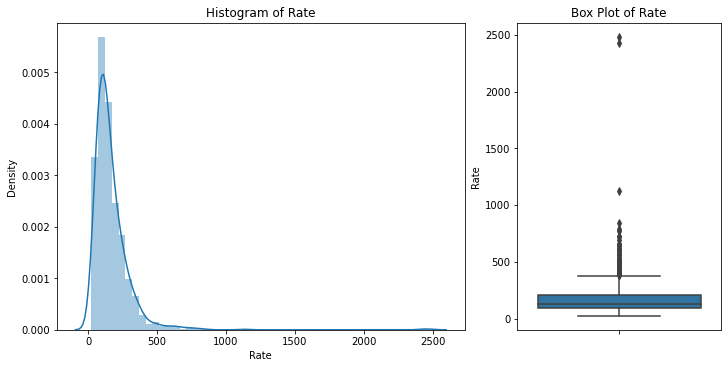

In [38]:
show_dist(df, 'Rate');

Looks better now :)

### #1 Filling NANs - KNN Imputation

Jednym z modeli, który na pewno wykorzystam będzie CatBoost, jako że w datasetcie jest sporo zmiennych jakościowych, a CatBoost nie wymaga encodowania zmiennych jakościowych, rozróżnię więc drugi dataframe `df_encoded` dla pozostałych modeli.

In [39]:
from fancyimpute import KNN
from sklearn.preprocessing import OrdinalEncoder

In [40]:
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Rate,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,194.833333,0
1,22,female,2,own,little,moderate,5951,48,radio/TV,123.979167,1
2,49,male,1,own,little,NaN,2096,12,education,174.666667,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,187.666667,0
4,53,male,2,free,little,little,4870,24,car,202.916667,1
...,...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,144.666667,0
996,40,male,3,own,little,little,3857,30,car,128.566667,0
997,38,male,2,own,little,NaN,804,12,radio/TV,67.000000,0
998,23,male,2,free,little,little,1845,45,radio/TV,41.000000,1


In [41]:
# instantiate both packages to use
df_knn = df.copy()
encoder_dict = {}
imputer = KNN()

# create a list of categorical columns to iterate over
cat_cols = df_knn.dtypes[df_knn.dtypes == 'object'].index.tolist()

def encode(data, encoder):
    '''function to encode non-null data and replace it in the original data'''
    # retains only non-null values
    nonulls = np.array(data.dropna())
    # reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    # encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    # Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#create a for loop to iterate through each column in the data
for column in cat_cols:
    encoder = OrdinalEncoder()
    encoder_dict[column] = encoder
    encode(df_knn[column], encoder)

In [42]:
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Rate,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,194.833333,0
1,22,female,2,own,little,moderate,5951,48,radio/TV,123.979167,1
2,49,male,1,own,little,NaN,2096,12,education,174.666667,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,187.666667,0
4,53,male,2,free,little,little,4870,24,car,202.916667,1
...,...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,144.666667,0
996,40,male,3,own,little,little,3857,30,car,128.566667,0
997,38,male,2,own,little,NaN,804,12,radio/TV,67.000000,0
998,23,male,2,free,little,little,1845,45,radio/TV,41.000000,1


In [43]:
# impute data and convert
df_knn = pd.DataFrame(np.round(imputer.fit_transform(df_knn)), columns = df_knn.columns)
df_knn

Imputing row 1/1000 with 1 missing, elapsed time: 0.118
Imputing row 101/1000 with 1 missing, elapsed time: 0.119
Imputing row 201/1000 with 1 missing, elapsed time: 0.120
Imputing row 301/1000 with 1 missing, elapsed time: 0.122
Imputing row 401/1000 with 1 missing, elapsed time: 0.123
Imputing row 501/1000 with 0 missing, elapsed time: 0.125
Imputing row 601/1000 with 0 missing, elapsed time: 0.127
Imputing row 701/1000 with 1 missing, elapsed time: 0.129
Imputing row 801/1000 with 1 missing, elapsed time: 0.130
Imputing row 901/1000 with 0 missing, elapsed time: 0.132


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Rate,Risk
0,67.0,1.0,2.0,1.0,0.0,0.0,1169.0,6.0,5.0,195.0,0.0
1,22.0,0.0,2.0,1.0,0.0,1.0,5951.0,48.0,5.0,124.0,1.0
2,49.0,1.0,1.0,1.0,0.0,0.0,2096.0,12.0,3.0,175.0,0.0
3,45.0,1.0,2.0,0.0,0.0,0.0,7882.0,42.0,4.0,188.0,0.0
4,53.0,1.0,2.0,0.0,0.0,0.0,4870.0,24.0,1.0,203.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
995,31.0,0.0,1.0,1.0,0.0,0.0,1736.0,12.0,4.0,145.0,0.0
996,40.0,1.0,3.0,1.0,0.0,0.0,3857.0,30.0,1.0,129.0,0.0
997,38.0,1.0,2.0,1.0,0.0,1.0,804.0,12.0,5.0,67.0,0.0
998,23.0,1.0,2.0,0.0,0.0,0.0,1845.0,45.0,5.0,41.0,1.0


In [44]:
missing(df_knn)

,num_missing,perc_missing


In [45]:
profile = ProfileReport(df_knn, title="Pandas Profiling Report", explorative=True)
correlations = profile.description_set['correlations']

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [46]:
correlations['cramers']['Risk'].sort_values(ascending=False)

Risk                1.000000
Housing             0.127334
Saving accounts     0.116461
Checking account    0.114442
Sex                 0.065969
Job                 0.000000
Name: Risk, dtype: float64

In [47]:
correlations['phi_k']['Risk'].sort_values(ascending=False)

Risk                1.000000
Duration            0.285273
Credit amount       0.240898
Saving accounts     0.175808
Age                 0.147761
Rate                0.135785
Purpose             0.108971
Sex                 0.103450
Housing             0.076848
Checking account    0.069045
Job                 0.000000
Name: Risk, dtype: float64

Widzimy drastyczną dekorelacje dla `Checking account` po zastosowaniu KNN Imputation, zwłaszcza dla współczynnika Phi-K `0.51 -> 0.07`.

In [48]:
for column in cat_cols:
    df_knn[column] = encoder_dict[column].inverse_transform(df_knn[column].values.reshape(-1, 1))

df_knn

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Rate,Risk
0,67.0,male,2,own,little,little,1169.0,6.0,radio/TV,195.0,0.0
1,22.0,female,2,own,little,moderate,5951.0,48.0,radio/TV,124.0,1.0
2,49.0,male,1,own,little,little,2096.0,12.0,education,175.0,0.0
3,45.0,male,2,free,little,little,7882.0,42.0,furniture/equipment,188.0,0.0
4,53.0,male,2,free,little,little,4870.0,24.0,car,203.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
995,31.0,female,1,own,little,little,1736.0,12.0,furniture/equipment,145.0,0.0
996,40.0,male,3,own,little,little,3857.0,30.0,car,129.0,0.0
997,38.0,male,2,own,little,moderate,804.0,12.0,radio/TV,67.0,0.0
998,23.0,male,2,free,little,little,1845.0,45.0,radio/TV,41.0,1.0


### #2 Filling NANs - KNN Imputer only for numeric variables

In [49]:
saving_acc = df.copy()
checking_acc = df.copy()

In [50]:
saving_acc = df[['Saving accounts', 'Credit amount', 'Duration', 'Rate']]
checking_acc = df[['Checking account', 'Credit amount', 'Duration', 'Rate']]
saving_acc.head()

,Saving accounts,Credit amount,Duration,Rate
0,NaN,1169,6,194.833333
1,little,5951,48,123.979167
2,little,2096,12,174.666667
3,little,7882,42,187.666667
4,little,4870,24,202.916667


In [51]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

saving_acc.iloc[:, 1:] = scaler.fit_transform(saving_acc.iloc[:, 1:])
checking_acc.iloc[:, 1:] = scaler.fit_transform(checking_acc.iloc[:, 1:])

In [52]:
encoder = OrdinalEncoder()
encoder_dict['Saving accounts'] = encoder
encode(saving_acc['Saving accounts'], encoder);

encoder = OrdinalEncoder()
encoder_dict['Checking account'] = encoder
encode(checking_acc['Checking account'], encoder);

In [53]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
imputer.fit_transform(saving_acc)
saving_acc = pd.DataFrame(imputer.fit_transform(saving_acc), columns = saving_acc.columns)
saving_acc['Saving accounts'] = np.round(saving_acc['Saving accounts'])
saving_acc

,Saving accounts,Credit amount,Duration,Rate
0,1.0,0.050567,0.029412,0.069461
1,0.0,0.313690,0.647059,0.040642
2,0.0,0.101574,0.117647,0.061259
3,0.0,0.419941,0.558824,0.066546
4,0.0,0.254209,0.294118,0.072749
...,...,...,...,...
995,0.0,0.081765,0.117647,0.049057
996,0.0,0.198470,0.382353,0.042508
997,0.0,0.030483,0.117647,0.017467
998,0.0,0.087763,0.602941,0.006892


In [54]:
imputer = KNNImputer(n_neighbors=5)
imputer.fit_transform(checking_acc)
checking_acc = pd.DataFrame(imputer.fit_transform(checking_acc), columns = checking_acc.columns)
checking_acc['Checking account'] = np.round(checking_acc['Checking account'])
checking_acc

,Checking account,Credit amount,Duration,Rate
0,0.0,0.050567,0.029412,0.069461
1,1.0,0.313690,0.647059,0.040642
2,0.0,0.101574,0.117647,0.061259
3,0.0,0.419941,0.558824,0.066546
4,0.0,0.254209,0.294118,0.072749
...,...,...,...,...
995,0.0,0.081765,0.117647,0.049057
996,0.0,0.198470,0.382353,0.042508
997,1.0,0.030483,0.117647,0.017467
998,0.0,0.087763,0.602941,0.006892


In [55]:
saving_acc['Saving accounts'].value_counts(), df_knn['Saving accounts'].value_counts()

(0.0    712
 1.0    174
 2.0     66
 3.0     48
 Name: Saving accounts, dtype: int64,
 little        724
 moderate      155
 quite rich     71
 rich           50
 Name: Saving accounts, dtype: int64)

In [56]:
checking_acc['Checking account'].value_counts(), df_knn['Checking account'].value_counts()

(1.0    519
 0.0    413
 2.0     68
 Name: Checking account, dtype: int64,
 moderate    500
 little      426
 rich         74
 Name: Checking account, dtype: int64)

In [57]:
df_knn_numerical = df.copy()
df_knn_numerical['Checking account'] = checking_acc['Checking account']
df_knn_numerical['Saving accounts'] = saving_acc['Saving accounts']

### #3 Filling NANs - 'moderate' category

In [58]:
df_moderate = df.copy()
for feature in missing(df).index:
    df_moderate[feature] = df_moderate[feature].fillna('moderate')

### #4 Filling NANs - TDS KNN Imputation article

In [59]:
df_knn_tds = df.copy()

In [60]:
colnames = ['Age', 'Credit amount', 'Duration', 'Rate']

scaler = MinMaxScaler()

df_knn_tds[colnames] = scaler.fit_transform(df_knn_tds[colnames])

In [61]:
df_knn_tds.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Rate                  0
Risk                  0
dtype: int64

In [62]:
from knn_impute import knn_impute

checking_acc = knn_impute(target=df_knn_tds['Checking account'],
                          attributes=df_knn_tds.drop(['Checking account', 'Saving accounts'], 1),
                          aggregation_method="mode", k_neighbors=5, numeric_distance='euclidean',
                          categorical_distance='hamming', missing_neighbors_threshold=0.8)

saving_acc = knn_impute(target=df_knn_tds['Saving accounts'],
                        attributes=df_knn_tds.drop(['Checking account', 'Saving accounts'], 1),
                        aggregation_method="mode", k_neighbors=5, numeric_distance='euclidean',
                        categorical_distance='hamming', missing_neighbors_threshold=0.8)

In [63]:
checking_acc = checking_acc.fillna('NAN')

df_knn_tds = df.copy()
df_knn_tds['Checking account'] = checking_acc
df_knn_tds['Saving accounts'] = saving_acc

In [64]:
df_knn_tds

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Rate,Risk
0,67,male,2,own,little,little,1169,6,radio/TV,194.833333,0
1,22,female,2,own,little,moderate,5951,48,radio/TV,123.979167,1
2,49,male,1,own,little,little,2096,12,education,174.666667,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,187.666667,0
4,53,male,2,free,little,little,4870,24,car,202.916667,1
...,...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,little,1736,12,furniture/equipment,144.666667,0
996,40,male,3,own,little,little,3857,30,car,128.566667,0
997,38,male,2,own,little,little,804,12,radio/TV,67.000000,0
998,23,male,2,free,little,little,1845,45,radio/TV,41.000000,1


### #5 Filling NANs - 'NAN' category

In [65]:
for feature in missing(df).index:
    df[feature] = df[feature].fillna('NAN')

In [66]:
missing(df)

,num_missing,perc_missing


### Polynomial features

In [67]:
# df['Rate^2'] = df['Rate'] ** 2

In [68]:
# df['Credit amount^2'] = df['Credit amount'] ** 2

In [69]:
# df['Duration^2'] = df['Duration'] ** 2
# df['Amount_*_Duration'] = df['Credit amount'] * df['Duration']

### Categorical data encoding

In [70]:
df_oh = df.copy()
df_knn_oh = df_knn_tds.copy()

In [71]:
df_oh = pd.get_dummies(df_oh.iloc[:, :-1])
df_oh['Risk'] = df['Risk']

In [72]:
df_knn_oh = pd.get_dummies(df_knn_oh.iloc[:, :-1])
df_knn_oh['Risk'] = df['Risk'] #Saving accounts_quite rich

In [73]:
print(df_oh.columns.tolist())

['Age', 'Credit amount', 'Duration', 'Rate', 'Sex_female', 'Sex_male', 'Job_0', 'Job_1', 'Job_2', 'Job_3', 'Housing_free', 'Housing_own', 'Housing_rent', 'Saving accounts_NAN', 'Saving accounts_little', 'Saving accounts_moderate', 'Saving accounts_quite rich', 'Saving accounts_rich', 'Checking account_NAN', 'Checking account_little', 'Checking account_moderate', 'Checking account_rich', 'Purpose_business', 'Purpose_car', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs', 'Purpose_vacation/others', 'Risk']


### Splitting dataset

In [74]:
X_knn_oh = df_knn_oh.drop('Risk', axis=1)
y_knn_oh = df_knn_oh['Risk']
X_train_knn_oh, X_test_knn_oh, y_train_knn_oh, y_test_knn_oh = train_test_split(X_knn_oh, y_knn_oh, test_size=0.2,
                                                                                random_state=0, stratify=y_knn_oh)

X_oh = df_oh.drop('Risk', axis=1)
y_oh = df_oh['Risk']
X_train_oh, X_test_oh, y_train_oh, y_test_oh = train_test_split(X_oh, y_oh, test_size=0.2,
                                                                random_state=0, stratify=y_oh)

### Feature Scaling

In [75]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler

scaler_knn = PowerTransformer(method='box-cox')

X_train_knn_oh.iloc[:, :4] = scaler_knn.fit_transform(X_train_knn_oh.iloc[:, :4])
X_test_knn_oh.iloc[:, :4] = scaler_knn.transform(X_test_knn_oh.iloc[:, :4])

scaler_oh = PowerTransformer(method='box-cox')

X_train_oh.iloc[:, :4] = scaler_oh.fit_transform(X_train_oh.iloc[:, :4])
X_test_oh.iloc[:, :4] = scaler_oh.transform(X_test_oh.iloc[:, :4])

<br>

Jako modele do dalszego rozważania problemu wybrałem: 
- po pierwsze już wyżej wspomniany CatBoost, czyli algorytm GBDT z pewnymi innowacyjnymi usprawnieniami w stosunku do klasycznych algorytmów GBDT takich jak XGBoost,
- po drugie, klasycznie 'królowa' algorytmów klasyfikacji, czyli regresja logistyczna :)
- po trzecie Random Forest

Jako metrykę do ewaluacji problemu skupiam się wokół Precision -- chcemy, aby unikać False Positivów (nie chcemy, aby klienci, którzy powinni dostać kredyt go nie dostaną) aniżeli Recall (Ci którzy dostaną niesłusznie nie są aż tak krytyczni dla biznesu).

## LogReg evaluation on training set ('NAN' category)

In [76]:
logreg = LogisticRegression()

### 5-Fold CV with eval_sets

In [77]:
def logreg_cv(X_train, y_train, logreg):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scoring = {'precision': 'precision_macro',
               'recall': 'recall_macro',
               'accuracy': 'accuracy',
               'auc': 'roc_auc'}
    cv_results = []
    
    cv_logreg = cross_validate(logreg, X_train, y_train, scoring=scoring, cv=kfold)
    cv_results.append([cv_logreg['test_precision'].mean(), cv_logreg['test_recall'].mean(),
                       cv_logreg['test_accuracy'].mean(), cv_logreg['test_auc'].mean()])
    
    return cv_results

In [78]:
def show_cv_results(cv_results):
    cvr_df = pd.DataFrame(index=['Logisitc Regression'],
                          data=cv_results, columns=['precision', 'recall', 'accuracy', 'AUC'])
    return cvr_df

In [79]:
cv_results = logreg_cv(X_train_oh, y_train_oh, logreg)
show_cv_results(cv_results)

,precision,recall,accuracy,AUC
Logisitc Regression,0.657824,0.626274,0.72125,0.749036


### Hyperparameter Tuning using HyperOpt (L2 penalty)

In [80]:
def fun(params_bounds):
    model = LogisticRegression(C=params_bounds['C'],
                               max_iter=round(params_bounds['max_iter']),
                               class_weight=params_bounds['class_weight'],
                               solver=params_bounds['solver'],
                               fit_intercept=params_bounds['fit_intercept'],
                               warm_start=params_bounds['warm_start'])
    score = cross_val_score(model, X_train_oh, y_train_oh, cv=5, scoring='precision', error_score='raise').mean()
    
    return {'loss': -score, 'status': STATUS_OK}

In [81]:
params_bounds = {'C': hp.uniform('C', 0.1, 10),
                 'max_iter' : hp.uniform('max_iter', 100, 3000),
                 'class_weight' : hp.choice('class_weight', ['balanced', None]),
                 'solver' : hp.choice('solver', ['liblinear', 'lbfgs', 'saga']),
                 'warm_start' : hp.choice('warm_start', [True, False]),
                 'fit_intercept' : hp.choice('fit_intercept', [True, False])}

trials = Trials()
best_l2 = fmin(fn=fun,
            space=params_bounds,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=np.random.default_rng(42)
           )
best_l2['max_iter'] = round(best_l2['max_iter'])
best_l2['class_weight'] = ['balanced', None][best_l2['class_weight']]
best_l2['solver'] = ['liblinear', 'lbfgs', 'saga'][best_l2['solver']]
best_l2['warm_start'] = [True, False][best_l2['warm_start']]
best_l2['fit_intercept'] = [True, False][best_l2['fit_intercept']]

best_l2

100%|█████████████████████████████████████████████| 100/100 [00:07<00:00, 13.55trial/s, best loss: -0.6072140134403572]


{'C': 0.1616063377994985,
 'class_weight': None,
 'fit_intercept': False,
 'max_iter': 1077,
 'solver': 'liblinear',
 'warm_start': True}

### Hyperparameter Tuning using HyperOpt (L1 penalty)

In [82]:
def fun(params_bounds):
    model = LogisticRegression(C=params_bounds['C'],
                               max_iter=round(params_bounds['max_iter']),
                               class_weight=params_bounds['class_weight'],
                               solver=params_bounds['solver'],
                               fit_intercept=params_bounds['fit_intercept'],
                               warm_start=params_bounds['warm_start'],
                               penalty='l1')
    score = cross_val_score(model, X_train_oh, y_train_oh, cv=5, scoring='precision', error_score='raise').mean()
    
    return {'loss': -score, 'status': STATUS_OK}

In [83]:
# params_bounds = {'C': hp.uniform('C', 0.1, 10),
#                  'max_iter' : hp.uniform('max_iter', 100, 3000),
#                  'class_weight' : hp.choice('class_weight', ['balanced', None]),
#                  'solver' : hp.choice('solver', ['liblinear', 'saga']),
#                  'warm_start' : hp.choice('warm_start', [True, False]),
#                  'fit_intercept' : hp.choice('fit_intercept', [True, False])}

# trials = Trials()
# best_l1 = fmin(fn=fun,
#             space=params_bounds,
#             algo=tpe.suggest,
#             max_evals=100,
#             trials=trials,
#             #rstate=np.random.default_rng(42)
#            )
# best_l1['max_iter'] = round(best_l1['max_iter'])
# best_l1['class_weight'] = ['balanced', None][best_l1['class_weight']]
# best_l1['solver'] = ['liblinear', 'saga'][best_l1['solver']]
# best_l1['warm_start'] = [True, False][best_l1['warm_start']]
# best_l1['fit_intercept'] = [True, False][best_l1['fit_intercept']]

# best_l1

### Hyperparameter Tuning using HyperOpt (elasticnet penalty)

In [84]:
def fun(params_bounds):
    model = LogisticRegression(C=params_bounds['C'],
                               max_iter=round(params_bounds['max_iter']),
                               class_weight=params_bounds['class_weight'],
                               solver=params_bounds['solver'],
                               fit_intercept=params_bounds['fit_intercept'],
                               warm_start=params_bounds['warm_start'],
                               penalty='elasticnet',
                               l1_ratio=params_bounds['l1_ratio'])
    score = cross_val_score(model, X_train_oh, y_train_oh, cv=5, scoring='precision', error_score='raise').mean()
    
    return {'loss': -score, 'status': STATUS_OK}

In [85]:
# params_bounds = {'C': hp.uniform('C', 0.1, 10),
#                  'max_iter' : hp.uniform('max_iter', 100, 3000),
#                  'class_weight' : hp.choice('class_weight', ['balanced', None]),
#                  'solver' : hp.choice('solver', ['saga']),
#                  'warm_start' : hp.choice('warm_start', [True, False]),
#                  'fit_intercept' : hp.choice('fit_intercept', [True, False]),
#                  'l1_ratio': hp.uniform('l1_ratio', 0, 1)}

# trials = Trials()
# best_en = fmin(fn=fun,
#             space=params_bounds,
#             algo=tpe.suggest,
#             max_evals=100,
#             trials=trials,
#             #rstate=np.random.default_rng(42)
#            )
# best_en['max_iter'] = round(best_en['max_iter'])
# best_en['class_weight'] = ['balanced', None][best_en['class_weight']]
# best_en['solver'] = ['saga'][best_en['solver']]
# best_en['warm_start'] = [True, False][best_en['warm_start']]
# best_en['fit_intercept'] = [True, False][best_en['fit_intercept']]

# best_en

Najlepiej spośród wszystkich wypada l2, więc to jej użyjemy do dalszej ewaluacji modelu.

### Feature Importances

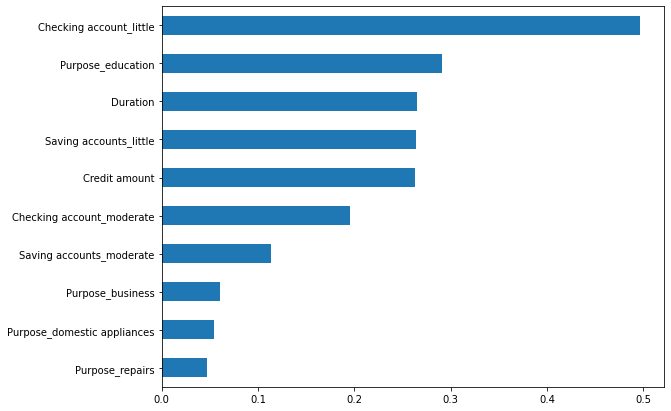

In [86]:
logreg = LogisticRegression(penalty='l2', **best_l2)
logreg.fit(X_train_oh, y_train_oh)

feat_importances = pd.Series(logreg.coef_[0], index=df_oh.iloc[:, :-1].columns).sort_values().nlargest(10)
feat_importances.sort_values().plot(kind='barh', figsize=[9, 7]);

## Tuned LogReg evaluation on test set ('NAN' category)

In [87]:
logreg = LogisticRegression(penalty='l2', **best_l2)
logreg.fit(X_train_oh, y_train_oh)

LogisticRegression(C=0.1616063377994985, fit_intercept=False, max_iter=1077,
                   solver='liblinear', warm_start=True)

In [89]:
prediction = logreg.predict(X_test_oh)
pred_proba = logreg.predict_proba(X_test_oh)[:, 1]

In [90]:
data=[[precision_score(y_test_oh, prediction),
       recall_score(y_test_oh, prediction),
       accuracy_score(y_test_oh, prediction),
       roc_auc_score(y_test_oh, pred_proba)]]
result_df = pd.DataFrame(index=['LogReg'],
                         data=data, columns=['precision', 'recall', 'accuracy', 'AUC']).T
result_df

,LogReg
precision,0.600000
recall,0.350000
accuracy,0.735000
AUC,0.756667


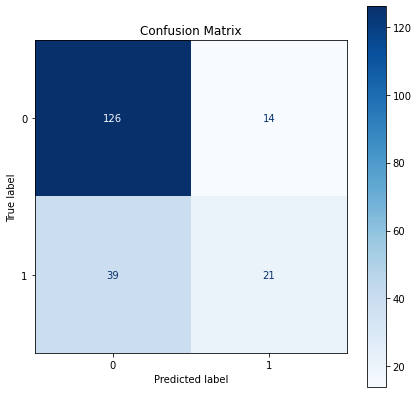

In [91]:
fig, ax = plt.subplots(figsize=(7, 7))
plt.title('Confusion Matrix')
plot_confusion_matrix(logreg, X_test_oh, y_test_oh, cmap='Blues', ax=ax);

### Threshold tuning

Best Threshold=0.250102, F-Score=0.565
Best Threshold=0.362991, F-Score=0.551
Best Threshold=0.324231, F-Score=0.636
Best Threshold=0.348625, F-Score=0.637
Best Threshold=0.312776, F-Score=0.678


0.31974496101594646

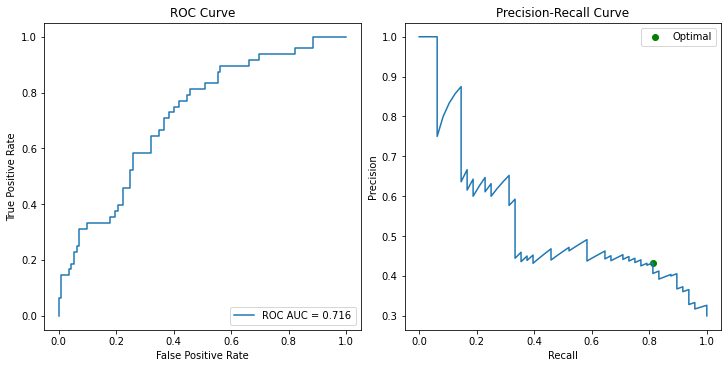

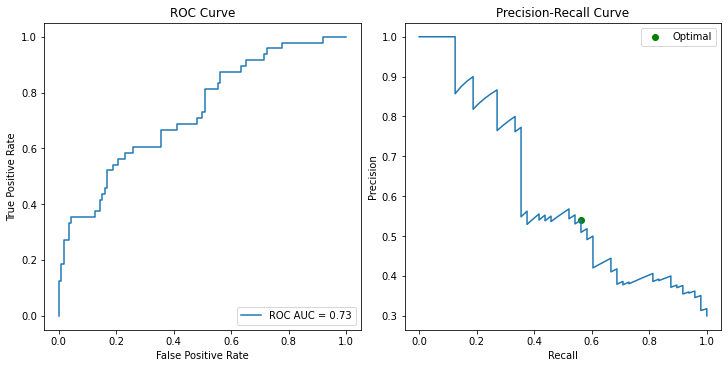

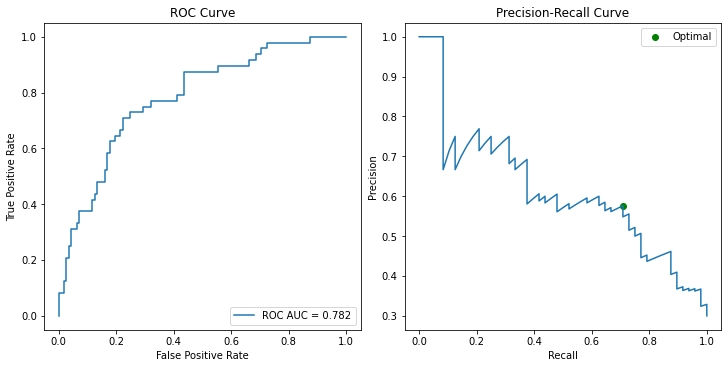

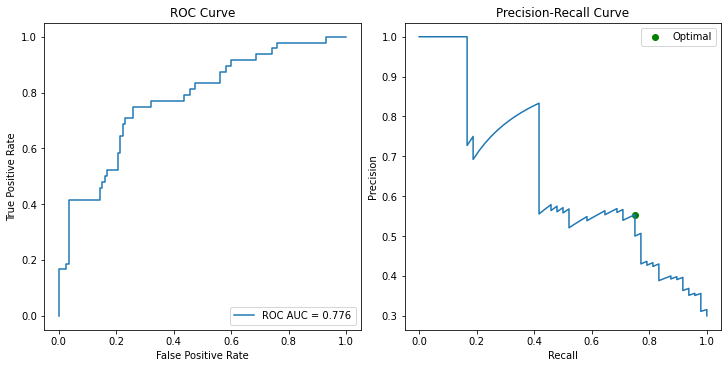

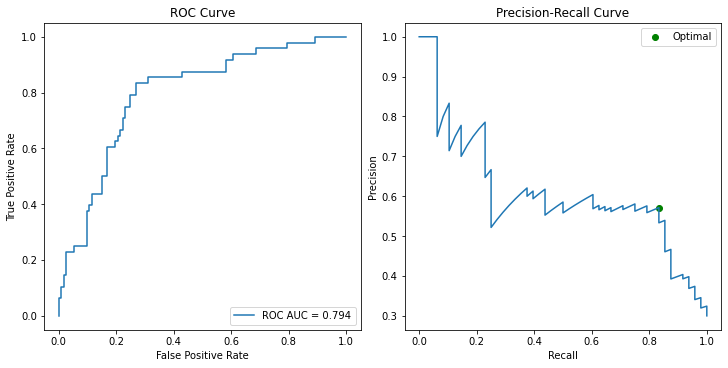

In [103]:
from cv_tune_threshold import cv_tune_threshold

logreg = LogisticRegression(penalty='l2', **best_l2)
threshold = cv_tune_threshold(logreg, X_train_oh, y_train_oh)
threshold

In [105]:
logreg = LogisticRegression(penalty='l2', **best_l2)
logreg.fit(X_train_oh, y_train_oh)

LogisticRegression(C=0.1616063377994985, fit_intercept=False, max_iter=1077,
                   solver='liblinear', warm_start=True)

Best Threshold=0.417460, F-Score=0.626


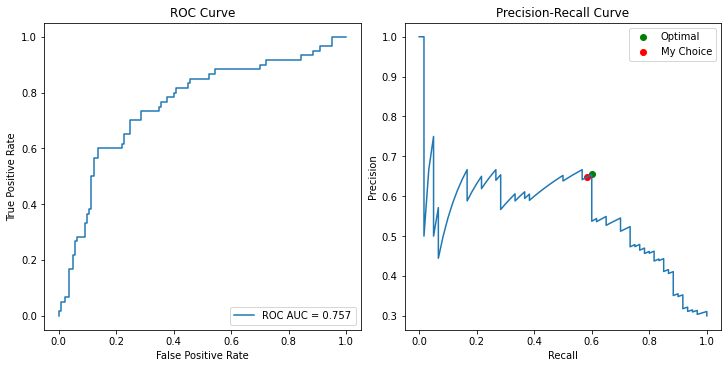

In [106]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
grid = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

y_pred_proba = logreg.predict_proba(X_test_oh)[:, 1]
fpr, tpr, _ = roc_curve(y_test_oh,  y_pred_proba)
auc = roc_auc_score(y_test_oh, y_pred_proba)

ax1 = fig.add_subplot(grid[0, 0])
ax1.set_title('ROC Curve')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, tpr, label="ROC AUC = " + str(round(auc, 3)))
ax1.legend(loc=4);

y_pred_proba = logreg.predict_proba(X_test_oh)[:, 1]
precision_, recall_, thresholds = precision_recall_curve(y_test_oh, y_pred_proba)
fscore_ = (2 * precision_ * recall_) / (precision_ + recall_)
fscore_ = fscore_[~np.isnan(fscore_)]

ix = np.argmax(fscore_)
my_ix = 146
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore_[ix]))

ax2 = fig.add_subplot(grid[0, 1])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.plot(recall_, precision_)
ax2.scatter(recall_[ix], precision_[ix], marker='o', color='green', label='Optimal');
ax2.scatter(recall_[my_ix], precision_[my_ix], marker='o', color='red', label='My Choice');

plt.legend();

In [107]:
threshold_tuned_pred = [1 if i >= thresholds[ix] else 0 for i in logreg.predict_proba(X_test_oh)[:, -1]]

In [108]:
data=[[precision_score(y_test_oh, prediction), precision_score(y_test_oh, threshold_tuned_pred)],
      [recall_score(y_test_oh, prediction), recall_score(y_test_oh, threshold_tuned_pred)],
      #[f1_-score(y_test, prediction), f1_score(y_test, threshold_tuned_pred)],
      [accuracy_score(y_test_oh, prediction), accuracy_score(y_test_oh, threshold_tuned_pred)],
      [roc_auc_score(y_test_oh, pred_proba), roc_auc_score(y_test_oh, pred_proba)]]

result_df_logreg = pd.DataFrame(data=data,
                         columns=['before', 'after'],
                         index=['precision', 'recall', 'accuracy', 'AUC'])
result_df_logreg

,before,after
precision,0.600000,0.654545
recall,0.350000,0.600000
accuracy,0.735000,0.785000
AUC,0.756667,0.756667


In [286]:
from sklearn.metrics import classification_report

print(classification_report(y_test_oh, threshold_tuned_pred))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       140
           1       0.65      0.60      0.63        60

    accuracy                           0.79       200
   macro avg       0.74      0.73      0.74       200
weighted avg       0.78      0.79      0.78       200



## LogReg evaluation on training set (KNN Imputation)

In [287]:
logreg = LogisticRegression()

### 5-Fold CV with eval_sets

In [288]:
cv_results = logreg_cv(X_train_knn_oh, y_train_knn_oh, logreg)
show_cv_results(cv_results)

,precision,recall,accuracy,AUC
Logisitc Regression,0.633153,0.568689,0.70875,0.664307


### Hyperparameter Tuning using HyperOpt

In [289]:
def fun(params_bounds):
    model = LogisticRegression(C=params_bounds['C'],
                               max_iter=round(params_bounds['max_iter']),
                               class_weight=params_bounds['class_weight'],
                               solver=params_bounds['solver'],
                               warm_start=params_bounds['warm_start'])
    score = cross_val_score(model, X_train_knn_oh, y_train_knn_oh,
                            cv=5, scoring='precision', error_score='raise').mean()
    
    return {'loss': -score, 'status': STATUS_OK}

In [290]:
params_bounds = {'C': hp.uniform('C', 0.1, 10),
                 'max_iter' : hp.uniform('max_iter', 100, 3000),
                 'class_weight' : hp.choice('class_weight', ['balanced', None]),
                 'solver' : hp.choice('solver', ['liblinear', 'lbfgs']),
                 'warm_start' : hp.choice('warm_start', [True, False])}

trials = Trials()
best = fmin(fn=fun,
            space=params_bounds,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            # rstate=np.random.default_rng(0)
           )
best['max_iter'] = round(best['max_iter'])
best['class_weight'] = ['balanced', None][best['class_weight']]
best['solver'] = ['liblinear', 'lbfgs'][best['solver']]
best['warm_start'] = [True, False][best['warm_start']]

best

100%|█████████████████████████████████████████████| 100/100 [00:06<00:00, 14.61trial/s, best loss: -0.5631482243246949]


{'C': 0.13320477657464735,
 'class_weight': None,
 'max_iter': 1641,
 'solver': 'lbfgs',
 'warm_start': False}

### Feature Importances

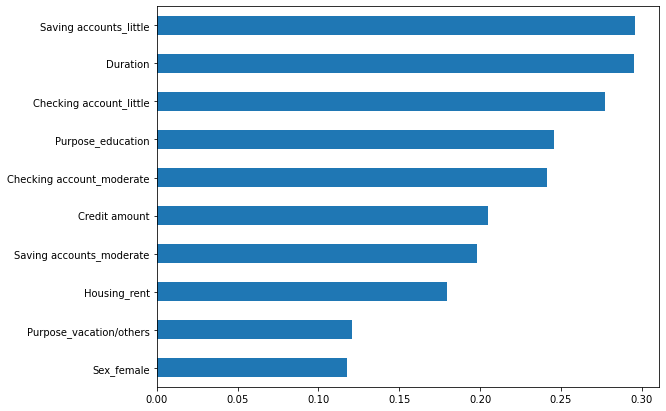

In [291]:
logreg = LogisticRegression(**best)
logreg.fit(X_train_knn_oh, y_train_knn_oh)

feat_importances = pd.Series(logreg.coef_[0], index=df_knn_oh.iloc[:, :-1].columns).sort_values().nlargest(10)
feat_importances.sort_values().plot(kind='barh', figsize=[9, 7]);

## Tuned LogReg evaluation on test set (KNN Imputation)

In [292]:
logreg = LogisticRegression(**best)
logreg.fit(X_train_knn_oh, y_train_knn_oh)

LogisticRegression(C=0.13320477657464735, max_iter=1641)

In [293]:
prediction = logreg.predict(X_test_knn_oh)
pred_proba = logreg.predict_proba(X_test_knn_oh)[:, 1]

In [294]:
data=[[precision_score(y_test_knn_oh, prediction),
       recall_score(y_test_knn_oh, prediction),
       accuracy_score(y_test_knn_oh, prediction),
       roc_auc_score(y_test_knn_oh, pred_proba)]]
result_df = pd.DataFrame(index=['LogReg'],
                         data=data, columns=['precision', 'recall', 'accuracy', 'AUC']).T
result_df

,LogReg
precision,0.500000
recall,0.116667
accuracy,0.700000
AUC,0.647143


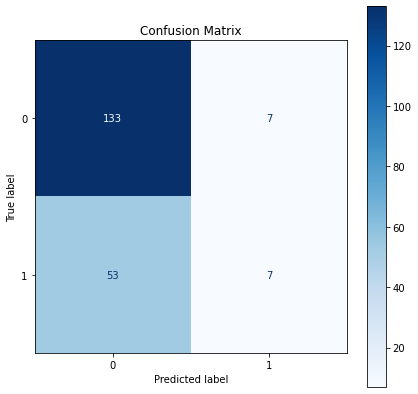

In [295]:
fig, ax = plt.subplots(figsize=(7, 7))
plt.title('Confusion Matrix')
plot_confusion_matrix(logreg, X_test_knn_oh, y_test_knn_oh, cmap='Blues', ax=ax);

### Threshold tuning

In [308]:
def cv_tune_threshold(model, X, y, k=5):
    result_thresholds = []
    for i in range(k):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)
        model.fit(X_train, y_train)
        
        fig = plt.figure(constrained_layout=True, figsize=(10, 5))
        grid = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

        y_pred_proba = model.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val,  y_pred_proba)
        auc = roc_auc_score(y_val, y_pred_proba)

        ax1 = fig.add_subplot(grid[0, 0])
        ax1.set_title('ROC Curve')
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.plot(fpr, tpr, label="ROC AUC = " + str(round(auc, 3)))
        ax1.legend(loc=4);

        precision_, recall_, thresholds = precision_recall_curve(y_val, y_pred_proba)
        fscore_ = (2 * precision_ * recall_) / (precision_ + recall_)
        fscore_ = fscore_[~np.isnan(fscore_)]

        ix = np.argmax(fscore_)
        print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore_[ix]))

        ax2 = fig.add_subplot(grid[0, 1])
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.set_title('Precision-Recall Curve')
        ax2.plot(recall_, precision_)
        ax2.scatter(recall_[ix], precision_[ix], marker='o', color='green', label='Optimal')

        plt.legend()
        #plt.show()
        result_thresholds.append(thresholds[ix])
        
    return np.mean(result_thresholds)

Best Threshold=0.248788, F-Score=0.529
Best Threshold=0.262378, F-Score=0.540
Best Threshold=0.199873, F-Score=0.533
Best Threshold=0.279010, F-Score=0.543
Best Threshold=0.276380, F-Score=0.532


0.2532858859046155

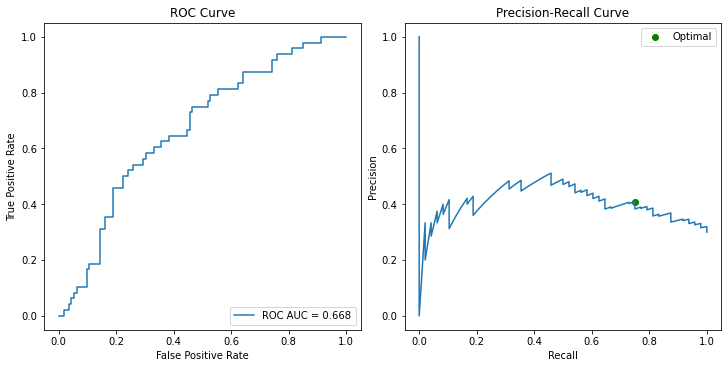

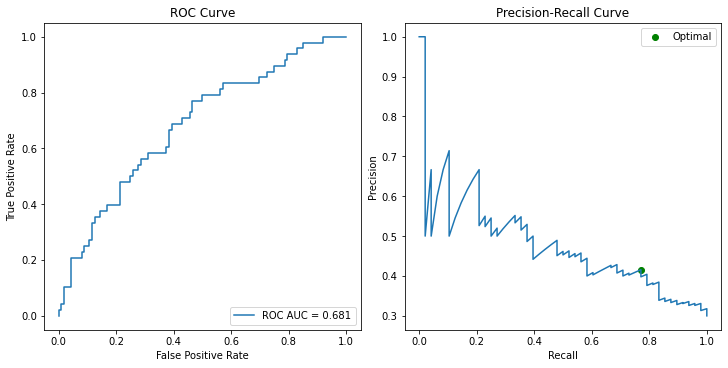

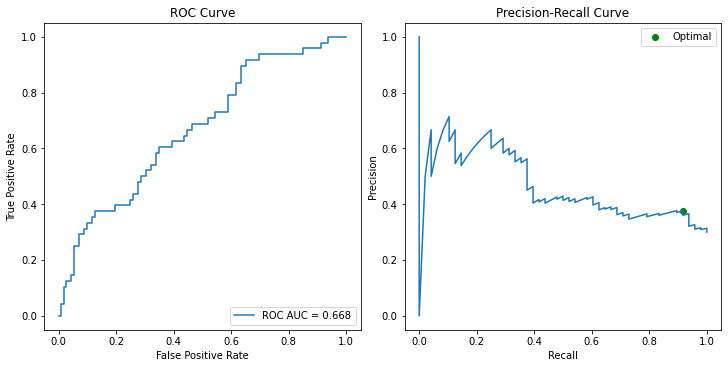

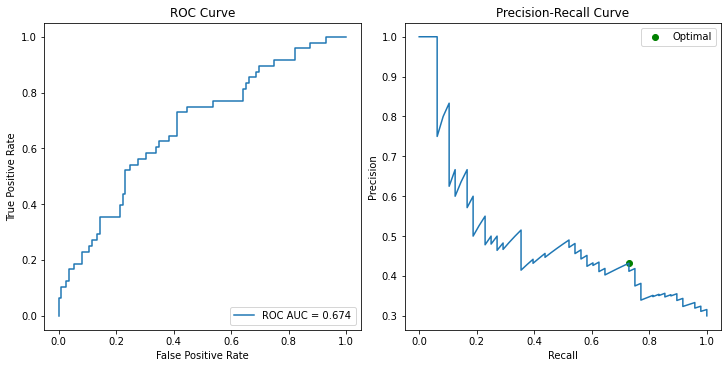

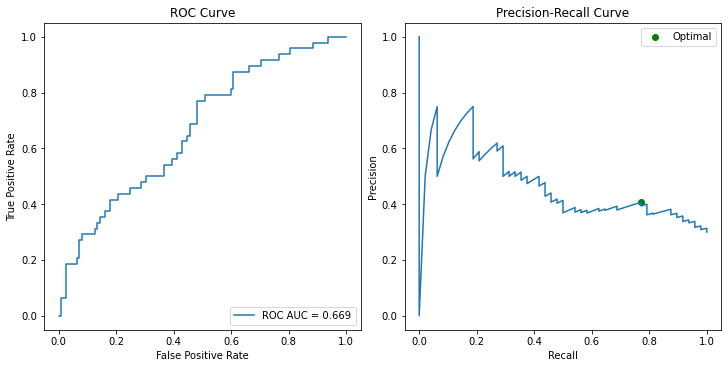

In [312]:
threshold = cv_tune_threshold(logreg, X_train_knn_oh, y_train_oh, k=5)
threshold

In [313]:
threshold_tuned_pred = [1 if i >= threshold else 0 for i in logreg.predict_proba(X_test_knn_oh)[:, -1]]

In [314]:
data=[[precision_score(y_test_knn_oh, prediction), precision_score(y_test_knn_oh, threshold_tuned_pred)],
      [recall_score(y_test_knn_oh, prediction), recall_score(y_test_knn_oh, threshold_tuned_pred)],
      #[f1_-score(y_test, prediction), f1_score(y_test, threshold_tuned_pred)],
      [accuracy_score(y_test_knn_oh, prediction), accuracy_score(y_test_knn_oh, threshold_tuned_pred)],
      [roc_auc_score(y_test_knn_oh, pred_proba), roc_auc_score(y_test_knn_oh, pred_proba)]]

result_df_logreg_knn = pd.DataFrame(data=data,
                                    columns=['before', 'after'],
                                    index=['precision', 'recall', 'accuracy', 'AUC'])
result_df_logreg_knn

,before,after
precision,0.500000,0.377193
recall,0.116667,0.716667
accuracy,0.700000,0.560000
AUC,0.647143,0.647143


In [315]:
output_logreg = pd.merge(result_df_logreg, result_df_logreg_knn, left_index=True, right_index=True, suffixes=['_nan', '_knn'])
output_logreg = output_logreg[['after_nan', 'after_knn']]
output_logreg = output_logreg.rename({'after_nan': 'logreg_nan', 'after_knn': 'logreg_knn'}, axis=1)
output_logreg

,logreg_nan,logreg_knn
precision,0.654545,0.377193
recall,0.600000,0.716667
accuracy,0.785000,0.560000
AUC,0.756667,0.647143


## Random Forest evaluation on training set

In [104]:
rf = RandomForestClassifier()

### 5-Fold CV with eval_sets

In [919]:
def rf_cv(X_train, y_train, rf):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scoring = {'precision': 'precision_macro',
               'recall': 'recall_macro',
               'accuracy': 'accuracy',
               'auc': 'roc_auc'}
    cv_results = []
    
    cv_rf = cross_validate(rf, X_train, y_train, scoring=scoring, cv=kfold)
    cv_results.append([cv_rf['test_precision'].mean(), cv_rf['test_recall'].mean(),
                       cv_rf['test_accuracy'].mean(), cv_rf['test_auc'].mean()])
    
    return cv_results

In [920]:
def show_cv_results(cv_results):
    cvr_df = pd.DataFrame(index=['Random Forest'],
                          data=cv_results, columns=['precision', 'recall', 'accuracy', 'AUC'])
    return cvr_df

In [921]:
cv_results = logreg_cv(X_train_oh, y_train_oh, rf)
show_cv_results(cv_results)

,precision,recall,accuracy,AUC
Random Forest,0.667927,0.630637,0.72625,0.753485


Without KNN imputation.

In [108]:
cv_results = logreg_cv(X_train_knn_oh, y_train_knn_oh, rf)
show_cv_results(cv_results)

,precision,recall,accuracy,AUC
Random Forest,0.649842,0.601837,0.715,0.682238


With KNN Imputation. Widzimy, że wyniki są gorsze, więc dla dalszej ewaluacji będziemy wykorzystywać zbiór danych bez KNN Imputation.

### Hyperparameter Tuning

In [109]:
from sklearn.metrics import make_scorer, matthews_corrcoef

def fun(params_bounds):
    model = RandomForestClassifier(n_estimators=round(params_bounds['n_estimators']),
                                   max_depth=params_bounds['max_depth'],
                                   criterion=params_bounds['criterion'],
                                   )
    score = cross_val_score(model, X_train_oh, y_train_oh, cv=5, scoring='f1', error_score='raise').mean()
    
    return {'loss': -score, 'status': STATUS_OK}

In [110]:
params_bounds = {'n_estimators':hp.uniform('n_estimators', 100, 500),
                 'max_depth': hp.choice('max_depth', range(1, 10)),
                 'criterion': hp.choice('criterion', ['gini', 'entropy'])
                }

trials = Trials()
best = fmin(fn=fun,
            space=params_bounds,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials,
            rstate=np.random.default_rng(1)
           )
best['n_estimators'] = round(best['n_estimators'])
best['criterion'] = ['gini', 'entropy'][best['criterion']]

best

100%|████████████████████████████████████████████████████| 50/50 [01:38<00:00,  1.98s/trial, best loss: -0.47227603201287416]


{'criterion': 'gini', 'max_depth': 7, 'n_estimators': 433}

### Feature importances

In [111]:
rf = RandomForestClassifier(**best)
rf.fit(X_train_oh, y_train_oh)

RandomForestClassifier(max_depth=7, n_estimators=433)

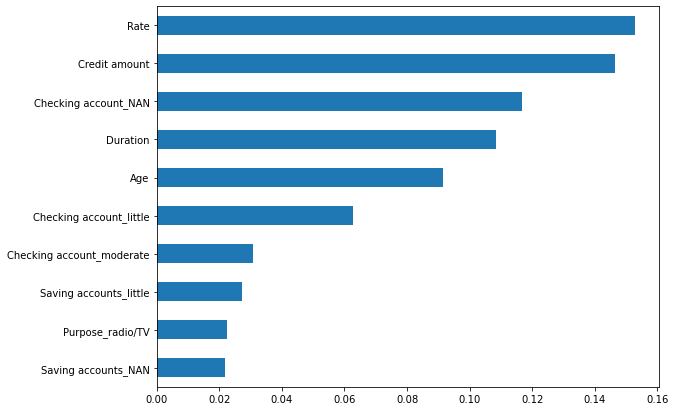

In [112]:
feat_importances = pd.Series(rf.feature_importances_, index=df_oh.iloc[:,:-1].columns).sort_values().nlargest(10)
feat_importances.sort_values().plot(kind='barh', figsize=[9, 7]);

## Random Forest evaluation on test set

In [113]:
prediction = rf.predict(X_test_oh)
pred_proba = rf.predict_proba(X_test_oh)[:, 1]

In [114]:
data=[[precision_score(y_test_oh, prediction),
       recall_score(y_test_oh, prediction),
       accuracy_score(y_test_oh, prediction),
       roc_auc_score(y_test_oh, pred_proba)]]
result_df = pd.DataFrame(index=['RF'],
                         data=data, columns=['precision', 'recall', 'accuracy', 'AUC']).T
result_df

,RF
precision,0.612903
recall,0.316667
accuracy,0.735000
AUC,0.768810


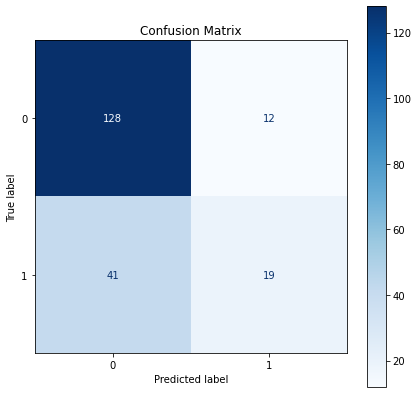

In [115]:
fig, ax = plt.subplots(figsize=(7, 7))
plt.title('Confusion Matrix')
plot_confusion_matrix(rf, X_test_oh, y_test_oh, cmap='Blues', ax=ax);

### Threshold tuning

Best Threshold=0.297685, F-Score=0.616


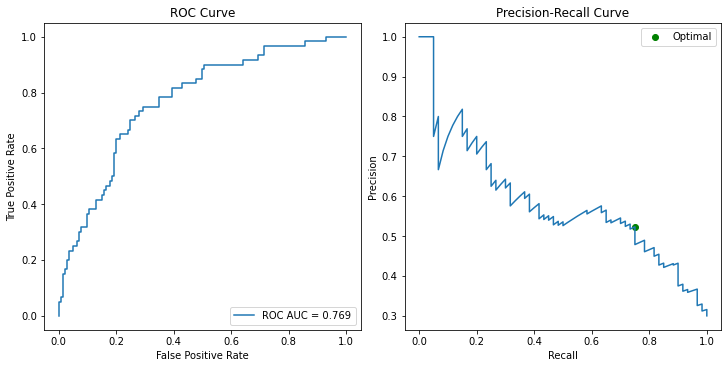

In [116]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
grid = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

y_pred_proba = rf.predict_proba(X_test_oh)[:, 1]
fpr, tpr, _ = roc_curve(y_test_oh,  y_pred_proba)
auc = roc_auc_score(y_test_oh, y_pred_proba)

ax1 = fig.add_subplot(grid[0, 0])
ax1.set_title('ROC Curve')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, tpr, label="ROC AUC = " + str(round(auc, 3)))
ax1.legend(loc=4);

y_pred_proba = rf.predict_proba(X_test_oh)[:, 1]
precision_, recall_, thresholds = precision_recall_curve(y_test_oh, y_pred_proba)
fscore_ = (2 * precision_ * recall_) / (precision_ + recall_)
fscore_ = fscore_[~np.isnan(fscore_)]

ix = np.argmax(fscore_)
# my_ix = 174
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore_[ix]))

ax2 = fig.add_subplot(grid[0, 1])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.plot(recall_, precision_)
ax2.scatter(recall_[ix], precision_[ix], marker='o', color='green', label='Optimal');
# ax2.scatter(recall_[my_ix], precision_[my_ix], marker='o', color='red', label='My Choice');

plt.legend();

In [117]:
threshold_tuned_pred = [1 if i >= thresholds[ix] else 0 for i in rf.predict_proba(X_test_oh)[:, -1]]

In [118]:
data=[[precision_score(y_test_oh, prediction), precision_score(y_test_oh, threshold_tuned_pred)],
      [recall_score(y_test_oh, prediction), recall_score(y_test_oh, threshold_tuned_pred)],
      #[f1_-score(y_test, prediction), f1_score(y_test, threshold_tuned_pred)],
      [accuracy_score(y_test_oh, prediction), accuracy_score(y_test_oh, threshold_tuned_pred)],
      [roc_auc_score(y_test_oh, pred_proba), roc_auc_score(y_test_oh, pred_proba)]]

result_df_rf = pd.DataFrame(data=data,
                            columns=['before', 'after'],
                            index=['precision', 'recall', 'accuracy', 'AUC'])
result_df_rf

,before,after
precision,0.612903,0.523256
recall,0.316667,0.750000
accuracy,0.735000,0.720000
AUC,0.768810,0.768810


In [119]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test_oh, threshold_tuned_pred)

array([[99, 41],
       [15, 45]], dtype=int64)

## CatBoost evaluation on training set

In [120]:
X = df.drop('Risk', axis=1)
y = df['Risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0, stratify=y)

In [121]:
cb = CatBoostClassifier(custom_metric=[cb_metrics.Accuracy(), cb_metrics.Precision(),
                                       cb_metrics.Recall(), cb_metrics.AUC()],
                        eval_metric=cb_metrics.F1(),
                        loss_function='Logloss',
                        task_type='CPU',
                        iterations=1000,
                        learning_rate=0.01,
                        random_seed=42)

cat_features_idxs = np.where(X_train.dtypes == object)[0]

### 5-Fold CV with eval_sets

In [122]:
cv_params = cb.get_params()

cv_data = cv(
    Pool(X_train, y_train, cat_features=cat_features_idxs),
    cv_params,
    nfold=5,
    verbose=333,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 179ms	remaining: 2m 58s
333:	learn: 0.6438356	test: 0.5000000	best: 0.5000000 (312)	total: 14.8s	remaining: 29.6s
666:	learn: 0.7663551	test: 0.6000000	best: 0.6067416 (518)	total: 28.3s	remaining: 14.1s
999:	learn: 0.8546512	test: 0.6041667	best: 0.6451613 (919)	total: 44s	remaining: 0us

bestTest = 0.6451612903
bestIteration = 919

Training on fold [1/5]
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 22ms	remaining: 22s
333:	learn: 0.7066246	test: 0.3030303	best: 0.3030303 (329)	total: 15.4s	remaining: 30.7s
666:	learn: 0.8023952	test: 0.3428571	best: 0.3428571 (658)	total: 31.4s	remaining: 15.7s
999:	learn: 0.8563050	test: 0.3611111	best: 0.3661972 (863)	total: 46.6s	remaining: 0us

bestTest = 0.3661971831
bestIteration = 863

Training on fold [2/5]
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 12.2ms	remaining: 12.2s
333:	learn: 0.6796117	test: 0.5000000	best: 0.50

In [123]:
cv_data

,iterations,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-Accuracy-mean,...,test-Precision-mean,test-Precision-std,train-Precision-mean,train-Precision-std,test-Recall-mean,test-Recall-std,train-Recall-mean,train-Recall-std,test-AUC-mean,test-AUC-std
0,0,0.068571,0.153330,0.092617,0.207099,0.689810,0.000367,0.689823,0.000602,0.70250,...,0.909091,0.203279,0.930189,0.156103,0.050000,0.111803,0.071875,0.160717,0.693750,0.023135
1,1,0.200889,0.154644,0.272552,0.172597,0.686488,0.000807,0.686461,0.000408,0.69375,...,0.576611,0.282376,0.740401,0.153575,0.145833,0.125865,0.187500,0.124891,0.725986,0.048433
2,2,0.179090,0.222878,0.273581,0.211653,0.683125,0.001120,0.682842,0.000750,0.71125,...,0.706222,0.330949,0.768250,0.131530,0.129167,0.166927,0.193750,0.159914,0.736272,0.034294
3,3,0.240694,0.171820,0.329855,0.178139,0.679593,0.001952,0.679076,0.000946,0.70750,...,0.604047,0.300693,0.705411,0.037581,0.170833,0.128763,0.231250,0.130759,0.744215,0.033746
4,4,0.283624,0.107058,0.412358,0.060985,0.676549,0.001964,0.675126,0.000893,0.70375,...,0.518585,0.173442,0.746136,0.049528,0.200000,0.086653,0.289583,0.062130,0.735398,0.035917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,0.505997,0.092839,0.860736,0.006847,0.512345,0.032087,0.266890,0.006326,0.75125,...,0.618896,0.048880,0.961892,0.017677,0.437500,0.124129,0.779167,0.015005,0.773177,0.031056
996,996,0.505997,0.092839,0.860736,0.006847,0.512423,0.032075,0.266779,0.006351,0.75125,...,0.618896,0.048880,0.961892,0.017677,0.437500,0.124129,0.779167,0.015005,0.773065,0.031097
997,997,0.505997,0.092839,0.860736,0.006847,0.512435,0.032156,0.266610,0.006299,0.75125,...,0.618896,0.048880,0.961892,0.017677,0.437500,0.124129,0.779167,0.015005,0.773065,0.031253
998,998,0.505997,0.092839,0.860736,0.006847,0.512488,0.032158,0.266372,0.006389,0.75125,...,0.618896,0.048880,0.961892,0.017677,0.437500,0.124129,0.779167,0.015005,0.772991,0.031244


In [124]:
best_iterations = cv_data['test-Logloss-mean'].argmin()
best_iterations

527

### Training on the whole training set

In [125]:
params = cb.get_params().copy()
params.update({'iterations': best_iterations})
cb = CatBoostClassifier(**params)

cb.fit(
    Pool(X_train, y_train, cat_features=cat_features_idxs),
    # eval_set = Pool(X_test, y_test, cat_features=cat_features_idxs),
    verbose=50,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5113924	total: 34.5ms	remaining: 18.1s
50:	learn: 0.4471299	total: 1.95s	remaining: 18.2s
100:	learn: 0.5044510	total: 3.83s	remaining: 16.2s
150:	learn: 0.5356125	total: 5.82s	remaining: 14.5s
200:	learn: 0.5666667	total: 8.29s	remaining: 13.4s
250:	learn: 0.6054054	total: 10.4s	remaining: 11.4s
300:	learn: 0.6310160	total: 12.5s	remaining: 9.36s
350:	learn: 0.6543536	total: 14.6s	remaining: 7.34s
400:	learn: 0.6735219	total: 16.9s	remaining: 5.29s
450:	learn: 0.6903553	total: 19.2s	remaining: 3.24s
500:	learn: 0.7245658	total: 21.7s	remaining: 1.13s
526:	learn: 0.7326733	total: 22.9s	remaining: 0us


### Feature Importances

In [126]:
feature_importances = cb.get_feature_importance()
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

Checking account: 24.966274354710894
Saving accounts: 11.136155198063856
Duration: 10.887909335997103
Rate: 10.710490687810434
Purpose: 9.753213694134415
Housing: 8.329487304343285
Job: 7.613435439796608
Credit amount: 6.878116784247414
Age: 6.134975023107308
Sex: 3.589942177788618


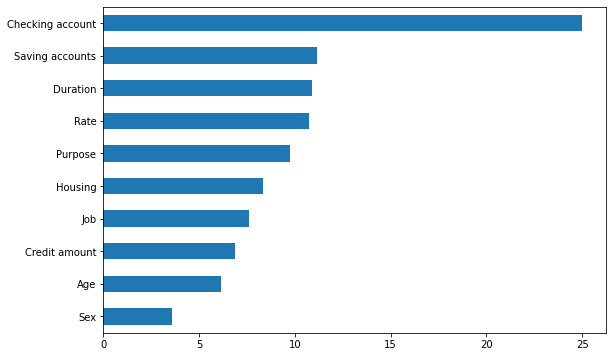

In [127]:
feat_importances = pd.Series(cb.feature_importances_, index=X_train.columns).sort_values().nlargest(10)
feat_importances.sort_values().plot(kind='barh', figsize=[9, 6]);

## CatBoost evaluation on test set

In [128]:
prediction = cb.predict(X_test)
pred_proba = cb.predict_proba(X_test)[:, 1]

In [129]:
data=[[precision_score(y_test, prediction),
       recall_score(y_test, prediction),
       accuracy_score(y_test, prediction),
       roc_auc_score(y_test, pred_proba)]]
result_df = pd.DataFrame(index=['CatBoost'],
                         data=data, columns=['precision', 'recall', 'accuracy', 'AUC']).T
result_df

,CatBoost
precision,0.600000
recall,0.350000
accuracy,0.735000
AUC,0.758929


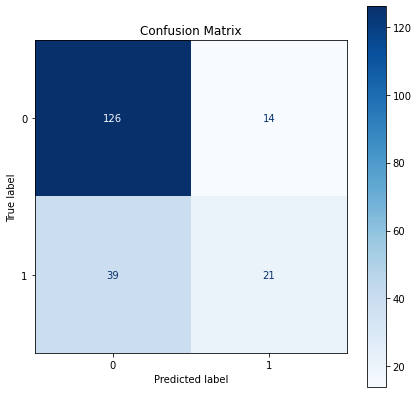

In [130]:
fig, ax = plt.subplots(figsize=(7, 7))
plt.title('Confusion Matrix')
plot_confusion_matrix(cb, X_test, y_test, cmap='Blues', ax=ax);

### Threshold tuning

Best Threshold=0.285316, F-Score=0.611
My Threshold=0.442432, F-Score=0.505


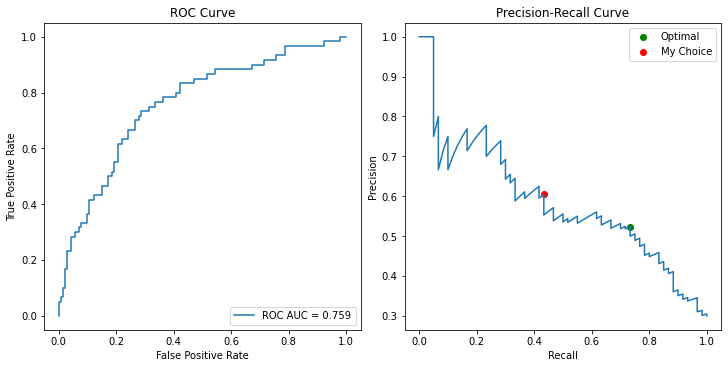

In [131]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
grid = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

y_pred_proba = cb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

ax1 = fig.add_subplot(grid[0, 0])
ax1.set_title('ROC Curve')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, tpr, label="ROC AUC = " + str(round(auc, 3)))
ax1.legend(loc=4);

y_pred_proba = cb.predict_proba(X_test)[:, 1]
precision_, recall_, thresholds = precision_recall_curve(y_test, y_pred_proba)
fscore_ = (2 * precision_ * recall_) / (precision_ + recall_)
ix = np.argmax(fscore_)
my_ix = 157
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore_[ix]))
print('My Threshold=%f, F-Score=%.3f' % (thresholds[my_ix], fscore_[my_ix]))

ax2 = fig.add_subplot(grid[0, 1])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.plot(recall_, precision_)
ax2.scatter(recall_[ix], precision_[ix], marker='o', color='green', label='Optimal');
ax2.scatter(recall_[my_ix], precision_[my_ix], marker='o', color='red', label='My Choice');

plt.legend();

In [132]:
threshold_tuned_pred = [1 if i >= thresholds[ix] else 0 for i in cb.predict_proba(X_test)[:, -1]]

In [133]:
data=[[precision_score(y_test, prediction), precision_score(y_test, threshold_tuned_pred)],
      [recall_score(y_test, prediction), recall_score(y_test, threshold_tuned_pred)],
      # [f1_score(y_test, prediction), f1_score(y_test, threshold_tuned_pred)],
      [accuracy_score(y_test, prediction), accuracy_score(y_test, threshold_tuned_pred)],
      [roc_auc_score(y_test, pred_proba), roc_auc_score(y_test, pred_proba)]]

result_df_cb = pd.DataFrame(data=data,
                            columns=['before', 'after'],
                            index=['precision', 'recall', 'accuracy',  'AUC'])
result_df_cb

,before,after
precision,0.600000,0.523810
recall,0.350000,0.733333
accuracy,0.735000,0.720000
AUC,0.758929,0.758929


In [134]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, threshold_tuned_pred)

array([[100,  40],
       [ 16,  44]], dtype=int64)

In [135]:
output = pd.merge(result_df_rf, result_df_cb, left_index=True, right_index=True, suffixes=['_rf', '_cb'])
output = output[['after_rf', 'after_cb']]
output = output.rename({'after_rf': 'rf', 'after_cb': 'cb'}, axis=1)

<br>

## Final Results

In [136]:
output_logreg

,logreg_nan,logreg_knn
precision,0.654545,0.416667
recall,0.600000,0.666667
accuracy,0.785000,0.620000
AUC,0.756667,0.645952


In [137]:
output

,rf,cb
precision,0.523256,0.523810
recall,0.750000,0.733333
accuracy,0.720000,0.720000
AUC,0.768810,0.758929


Najlepiej spośród wszystkich testowanych modeli wypada Regresja Logistyczna na zbiorze wypełnianym 'NAN'.

<br>

## SMOTE

In [909]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_oh, y_train_oh)

y_smote.value_counts()

0    560
1    560
Name: Risk, dtype: int64

Do SMOTE muszę użyć zakodowanych cech kategorycznych, dlatego w tym przypadku jako modelu użyję LogRega.

### RF SMOTE evaluation on training set

In [922]:
rf = RandomForestClassifier()

cv_results = logreg_cv(X_smote, y_smote, logreg)
show_cv_results(cv_results)

,precision,recall,accuracy,AUC
Random Forest,0.801227,0.798695,0.798214,0.886371


### Hyperparameter Tuning

In [923]:
from sklearn.metrics import make_scorer, matthews_corrcoef

def fun(params_bounds):
    model = RandomForestClassifier(n_estimators=round(params_bounds['n_estimators']),
                                   max_depth=params_bounds['max_depth'],
                                   criterion=params_bounds['criterion'],
                                   )
    score = cross_val_score(model, X_smote, y_smote, cv=5, scoring='f1', error_score='raise').mean()
    
    return {'loss': -score, 'status': STATUS_OK}

In [924]:
params_bounds = {'n_estimators':hp.uniform('n_estimators', 100, 500),
                 'max_depth': hp.choice('max_depth', range(1, 10)),
                 'criterion': hp.choice('criterion', ['gini', 'entropy'])
                }

trials = Trials()
best = fmin(fn=fun,
            space=params_bounds,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials,
            rstate=np.random.default_rng(0)
           )
best['n_estimators'] = round(best['n_estimators'])
best['criterion'] = ['gini', 'entropy'][best['criterion']]

best

100%|█████████████████████████████████████████████████████| 50/50 [01:25<00:00,  1.70s/trial, best loss: -0.8138168622196277]


{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 109}

In [925]:
# def fun(params_bounds):
#     model = LogisticRegression(C=params_bounds['C'],
#                                max_iter=round(params_bounds['max_iter']),
#                                class_weight=params_bounds['class_weight'],
#                                solver=params_bounds['solver'],
#                                fit_intercept=params_bounds['fit_intercept'],
#                                warm_start=params_bounds['warm_start'])
#     score = cross_val_score(model, X_smote, y_smote, cv=5, scoring='recall', error_score='raise').mean()
    
#     return {'loss': -score, 'status': STATUS_OK}

# params_bounds = {'C': hp.uniform('C', 0.1, 10),
#                  'max_iter' : hp.uniform('max_iter', 100, 3000),
#                  'class_weight' : hp.choice('class_weight', ['balanced', None]),
#                  'solver' : hp.choice('solver', ['liblinear', 'lbfgs']),
#                  'warm_start' : hp.choice('warm_start', [True, False]),
#                  'fit_intercept' : hp.choice('fit_intercept', [True, False])}

# trials = Trials()
# best = fmin(fn=fun,
#             space=params_bounds,
#             algo=tpe.suggest,
#             max_evals=100,
#             trials=trials,
#             # rstate=np.random.default_rng(0)
#            )
# best['max_iter'] = round(best['max_iter'])
# best['class_weight'] = ['balanced', None][best['class_weight']]
# best['solver'] = ['liblinear', 'lbfgs'][best['solver']]
# best['warm_start'] = [True, False][best['warm_start']]
# best['fit_intercept'] = [True, False][best['fit_intercept']]

# best

### LogReg SMOTE evaluation on test set

In [926]:
rf = RandomForestClassifier(**best)

rf.fit(X_smote, y_smote)

prediction = rf.predict(X_test_oh)
pred_proba = rf.predict_proba(X_test_oh)[:, 1]

data=[[precision_score(y_test_oh, prediction),
       recall_score(y_test_oh, prediction),
       accuracy_score(y_test_oh, prediction),
       roc_auc_score(y_test_oh, pred_proba)]]
result_df = pd.DataFrame(index=['RandomForest'],
                         data=data, columns=['precision', 'recall', 'accuracy', 'AUC']).T
result_df

,RandomForest
precision,0.560606
recall,0.616667
accuracy,0.740000
AUC,0.766071


Best Threshold=0.485510, F-Score=0.611


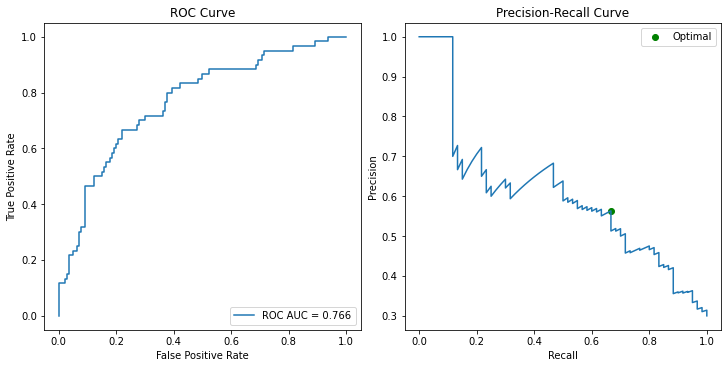

In [927]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
grid = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

y_pred_proba = rf.predict_proba(X_test_oh)[:, 1]
fpr, tpr, _ = roc_curve(y_test_oh,  y_pred_proba)
auc = roc_auc_score(y_test_oh, y_pred_proba)

ax1 = fig.add_subplot(grid[0, 0])
ax1.set_title('ROC Curve')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, tpr, label="ROC AUC = " + str(round(auc, 3)))
ax1.legend(loc=4);

y_pred_proba = rf.predict_proba(X_test_oh)[:, 1]
precision_, recall_, thresholds = precision_recall_curve(y_test_oh, y_pred_proba)
fscore_ = (2 * precision_ * recall_) / (precision_ + recall_)
ix = np.argmax(fscore_)
# my_ix = 39
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore_[ix]))

ax2 = fig.add_subplot(grid[0, 1])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.plot(recall_, precision_)
ax2.scatter(recall_[ix], precision_[ix], marker='o', color='green', label='Optimal');
# ax2.scatter(recall_[my_ix], precision_[my_ix], marker='o', color='red', label='My Choice');

plt.legend();

In [928]:
threshold_tuned_pred = [1 if i >= thresholds[ix] else 0 for i in rf.predict_proba(X_test_oh)[:, -1]]

In [929]:
data=[[precision_score(y_test_oh, prediction), precision_score(y_test_oh, threshold_tuned_pred)],
      [recall_score(y_test_oh, prediction), recall_score(y_test_oh, threshold_tuned_pred)],
      #[f1_-score(y_test, prediction), f1_score(y_test, threshold_tuned_pred)],
      [accuracy_score(y_test_oh, prediction), accuracy_score(y_test_oh, threshold_tuned_pred)],
      [roc_auc_score(y_test_oh, pred_proba), roc_auc_score(y_test_oh, pred_proba)]]

result_df_rf_smote = pd.DataFrame(data=data,
                         columns=['before', 'after'],
                         index=['precision', 'recall', 'accuracy', 'AUC'])
result_df_rf_smote

,before,after
precision,0.560606,0.563380
recall,0.616667,0.666667
accuracy,0.740000,0.745000
AUC,0.766071,0.766071


In [918]:
output

,rf,cb
precision,0.523256,0.523810
recall,0.750000,0.733333
accuracy,0.720000,0.720000
AUC,0.768810,0.758929


Widzimy poprawę jakości RF na zbiorze po zastosowaniu SMOTE, zwłaszcza zmniejszony recall bias.

## Dumping scaler and model

In [782]:
from pickle import dump

# save the model
dump(logreg, open('model.pkl', 'wb'))

# save the scale
r
dump(scaler_oh, open('scaler.pkl', 'wb'))